# Tutorial 4

Design Tissue Micro Array experiment for multiple breast biopsies

Please download according demo data from following link and place it under the demo folder:

google drive: https://drive.google.com/drive/folders/1z1nk0sF_e25LKMyHxJVMtROFjuWet2G_?usp=drive_link

Please also download the checkpoint file for the pathology foundation model and place it under the checkpoints folder

# Step 1: Preprocess the H&E image

Make sure the physical size of each pixel is 0.5 micron

Image loaded from ../demo/Tutorial_4_TMA_selection_breast/he-raw.jpg
Rescaling image (scale: 1.000)...
417 sec
../demo/Tutorial_4_TMA_selection_breast/he-scaled.jpg
../demo/Tutorial_4_TMA_selection_breast/he.jpg
Preprocessed H&E image saved!


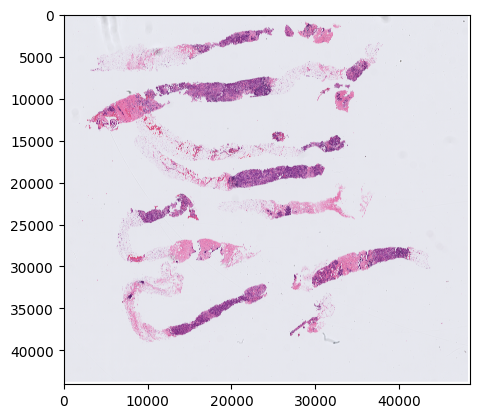

In [1]:
import sys
sys.path.append('../src')
from p1_histology_preprocess import histology_preprocess

prefix = '../demo/Tutorial_4_TMA_selection_breast/'
histology_preprocess(prefix, show_image=True)

# Step 2: Quality control for all superpixels

Superpixels are 8 microns * 8 microns square-shaped pseudo cells

We use our new QC package HistoSweep for this procedure

Image loaded from ../demo/Tutorial_4_TMA_selection_breast/he.jpg
0 0
../demo/Tutorial_4_TMA_selection_breast/S2Omics_output/pickle_files/shapes.pickle
[compute_metrics_memory_optimized] Current memory: 0.3100 GB; Peak memory: 6.2019 GB
[compute_low_density_mask] Current memory: 0.0078 GB; Peak memory: 0.5039 GB
Total selected for density filtering:  1098988
✅ Entropy map saved as 'glcm_entropy_map_colored.png'
✅ Energy map saved as 'glcm_energy_map_colored.png'
✅ Homogeneity map saved as 'glcm_homogeneity_map_colored.png'

=== GLCM Metric Means ===
   homogeneity    energy   entropy
0     0.304229  0.053498  0.816637
1     0.205236  0.024300  0.904989
2     0.498468  0.204954  0.652184
3     0.387707  0.090371  0.752841

=== Cluster Scores ===
Cluster 0: Score = -0.4589
Cluster 1: Score = -0.6755
Cluster 2: Score = 0.0512
Cluster 3: Score = -0.2748

=== Number of Observations per Cluster ===
Cluster 0: 260450
Cluster 1: 431591
Cluster 2: 48269
Cluster 3: 113460
Total: 853770

✅ Cluster

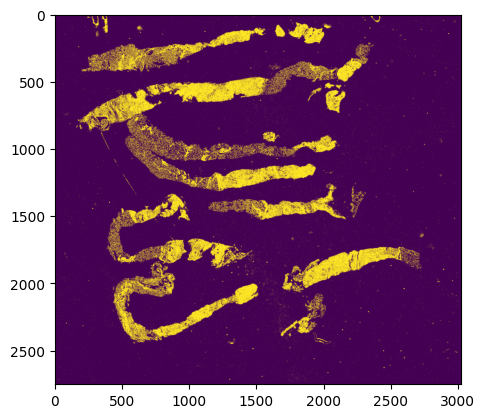

In [2]:
sys.path.append('../src/HistoSweep')
from p2_superpixel_quality_control import superpixel_quality_control

save_folder = '../demo/Tutorial_4_TMA_selection_breast/S2Omics_output'
superpixel_quality_control(prefix, save_folder, show_image=True)

# Step 3: Histology feature extraction

In [3]:
from p3_feature_extraction import histology_feature_extraction

# down_samp_step: the down-sampling step, 
# default = 10 refers to only extract features for superpixels whose row_index and col_index can both be divided by 10 (roughly 1:100 down-sampling rate). 
# down_samp_step = 1 means extract features for every superpixel
histology_feature_extraction(prefix, save_folder,
                             foundation_model='uni',
                             ckpt_path='../checkpoints/uni/',
                             device='cuda:2',
                             batch_size=32,
                             down_samp_step=10,
                             num_workers=4)

/data1/msyuan/anaconda3/envs/S2Omics/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Histology foundation model loaded! 
    Foundation model name: uni
    Start extracting histology feature embeddings...
Image loaded from ../demo/Tutorial_4_TMA_selection_breast/he.jpg
../demo/Tutorial_4_TMA_selection_breast/S2Omics_output/pickle_files/num_patches.pickle


  0%|          | 0/2614 [00:00<?, ?it/s]

Batch 0:
Shape of patches: torch.Size([32, 3, 224, 224])
Shape of positions[0]: torch.Size([32])
Content of positions[0][:10]: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Content of positions[1][:10]: tensor([   0,  160,  320,  480,  640,  800,  960, 1120, 1280, 1440])
Shape of feature_emb: torch.Size([32, 197, 1024])
Shape of patch_emb: torch.Size([32, 1024, 14, 14])


100%|█████████▉| 2613/2614 [52:39<00:01,  1.22s/it] 

Part 0 patch number: 83628


100%|██████████| 2614/2614 [52:42<00:00,  1.21s/it]

../demo/Tutorial_4_TMA_selection_breast/S2Omics_output/pickle_files/uni_embeddings_downsamp_10_part_0.pickle


# Step 4: Histology segmentation

Pickle loaded from ../demo/Tutorial_4_TMA_selection_breast/S2Omics_output/pickle_files/shapes.pickle
Pickle loaded from ../demo/Tutorial_4_TMA_selection_breast/S2Omics_output/pickle_files/qc_preserve_indicator.pickle
Loading histology feature embeddings...
Pickle loaded from ../demo/Tutorial_4_TMA_selection_breast/S2Omics_output/pickle_files/uni_embeddings_downsamp_10_part_0.pickle
Sucessfully loaded and normalized all histology feature embeddings!
Start segmenting the histology image, clustering method: kmeans
../demo/Tutorial_4_TMA_selection_breast/S2Omics_output/pickle_files/cluster_image.pickle
../demo/Tutorial_4_TMA_selection_breast/S2Omics_output/pickle_files/linkage_matrix.pickle
Segmentation image is stored at: ../demo/Tutorial_4_TMA_selection_breast/S2Omics_output/image_files/cluster_image_num_clusters_20.jpg


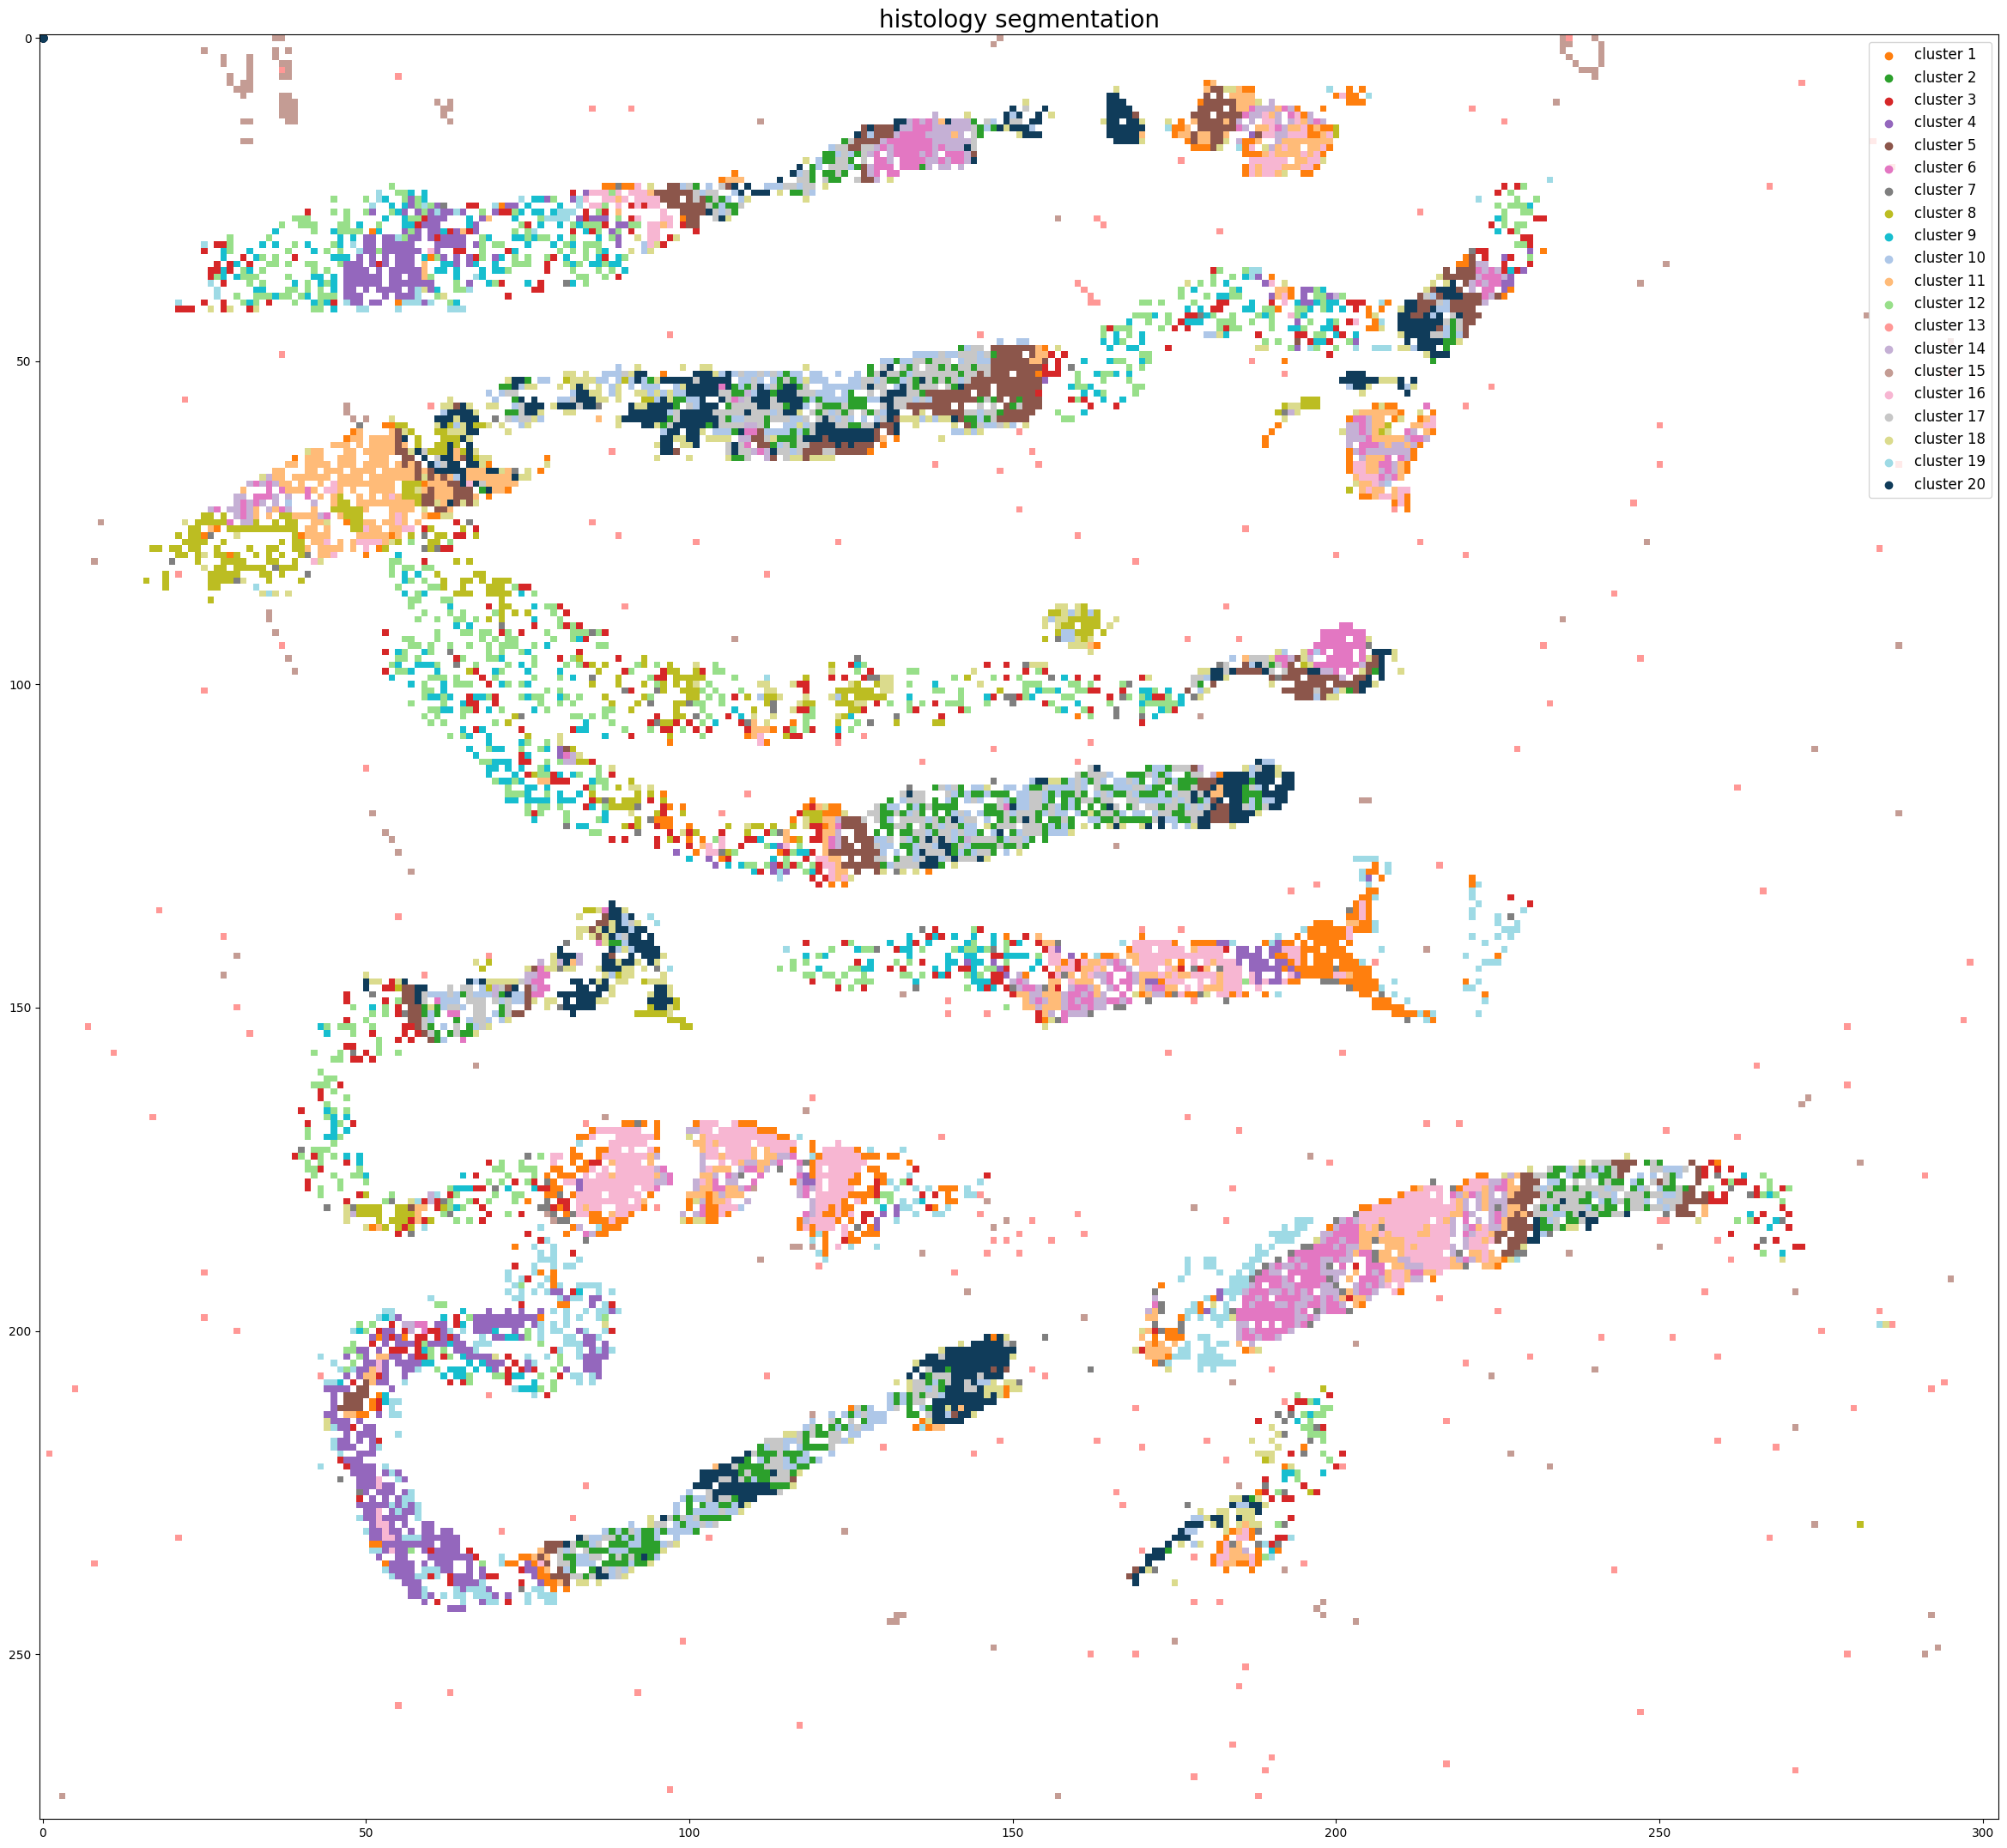

In [4]:
sys.path.append('../src/single_section')
from p4_get_histology_segmentation import get_histology_segmentation

get_histology_segmentation(prefix, save_folder,
                           foundation_model='uni', 
                           down_samp_step=10, 
                           clustering_method='kmeans',
                           n_clusters=20)

# Step 5: Merge over-clusters

Pickle loaded from ../demo/Tutorial_4_TMA_selection_breast/S2Omics_output/pickle_files/shapes.pickle
Pickle loaded from ../demo/Tutorial_4_TMA_selection_breast/S2Omics_output/pickle_files/qc_preserve_indicator.pickle
Pickle loaded from ../demo/Tutorial_4_TMA_selection_breast/S2Omics_output/pickle_files/cluster_image.pickle
Merging over-clusters...
Pickle loaded from ../demo/Tutorial_4_TMA_selection_breast/S2Omics_output/pickle_files/linkage_matrix.pickle
../demo/Tutorial_4_TMA_selection_breast/S2Omics_output/pickle_files/adjusted_cluster_image.pickle
Combined the original 20 clusters into 15 clusters.
Adjusted segmentation image is stored at: ../demo/Tutorial_4_TMA_selection_breast/S2Omics_output/image_files/adjusted_cluster_image_num_clusters_15.jpg


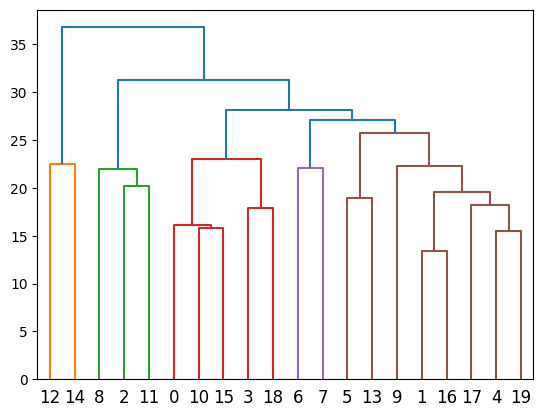

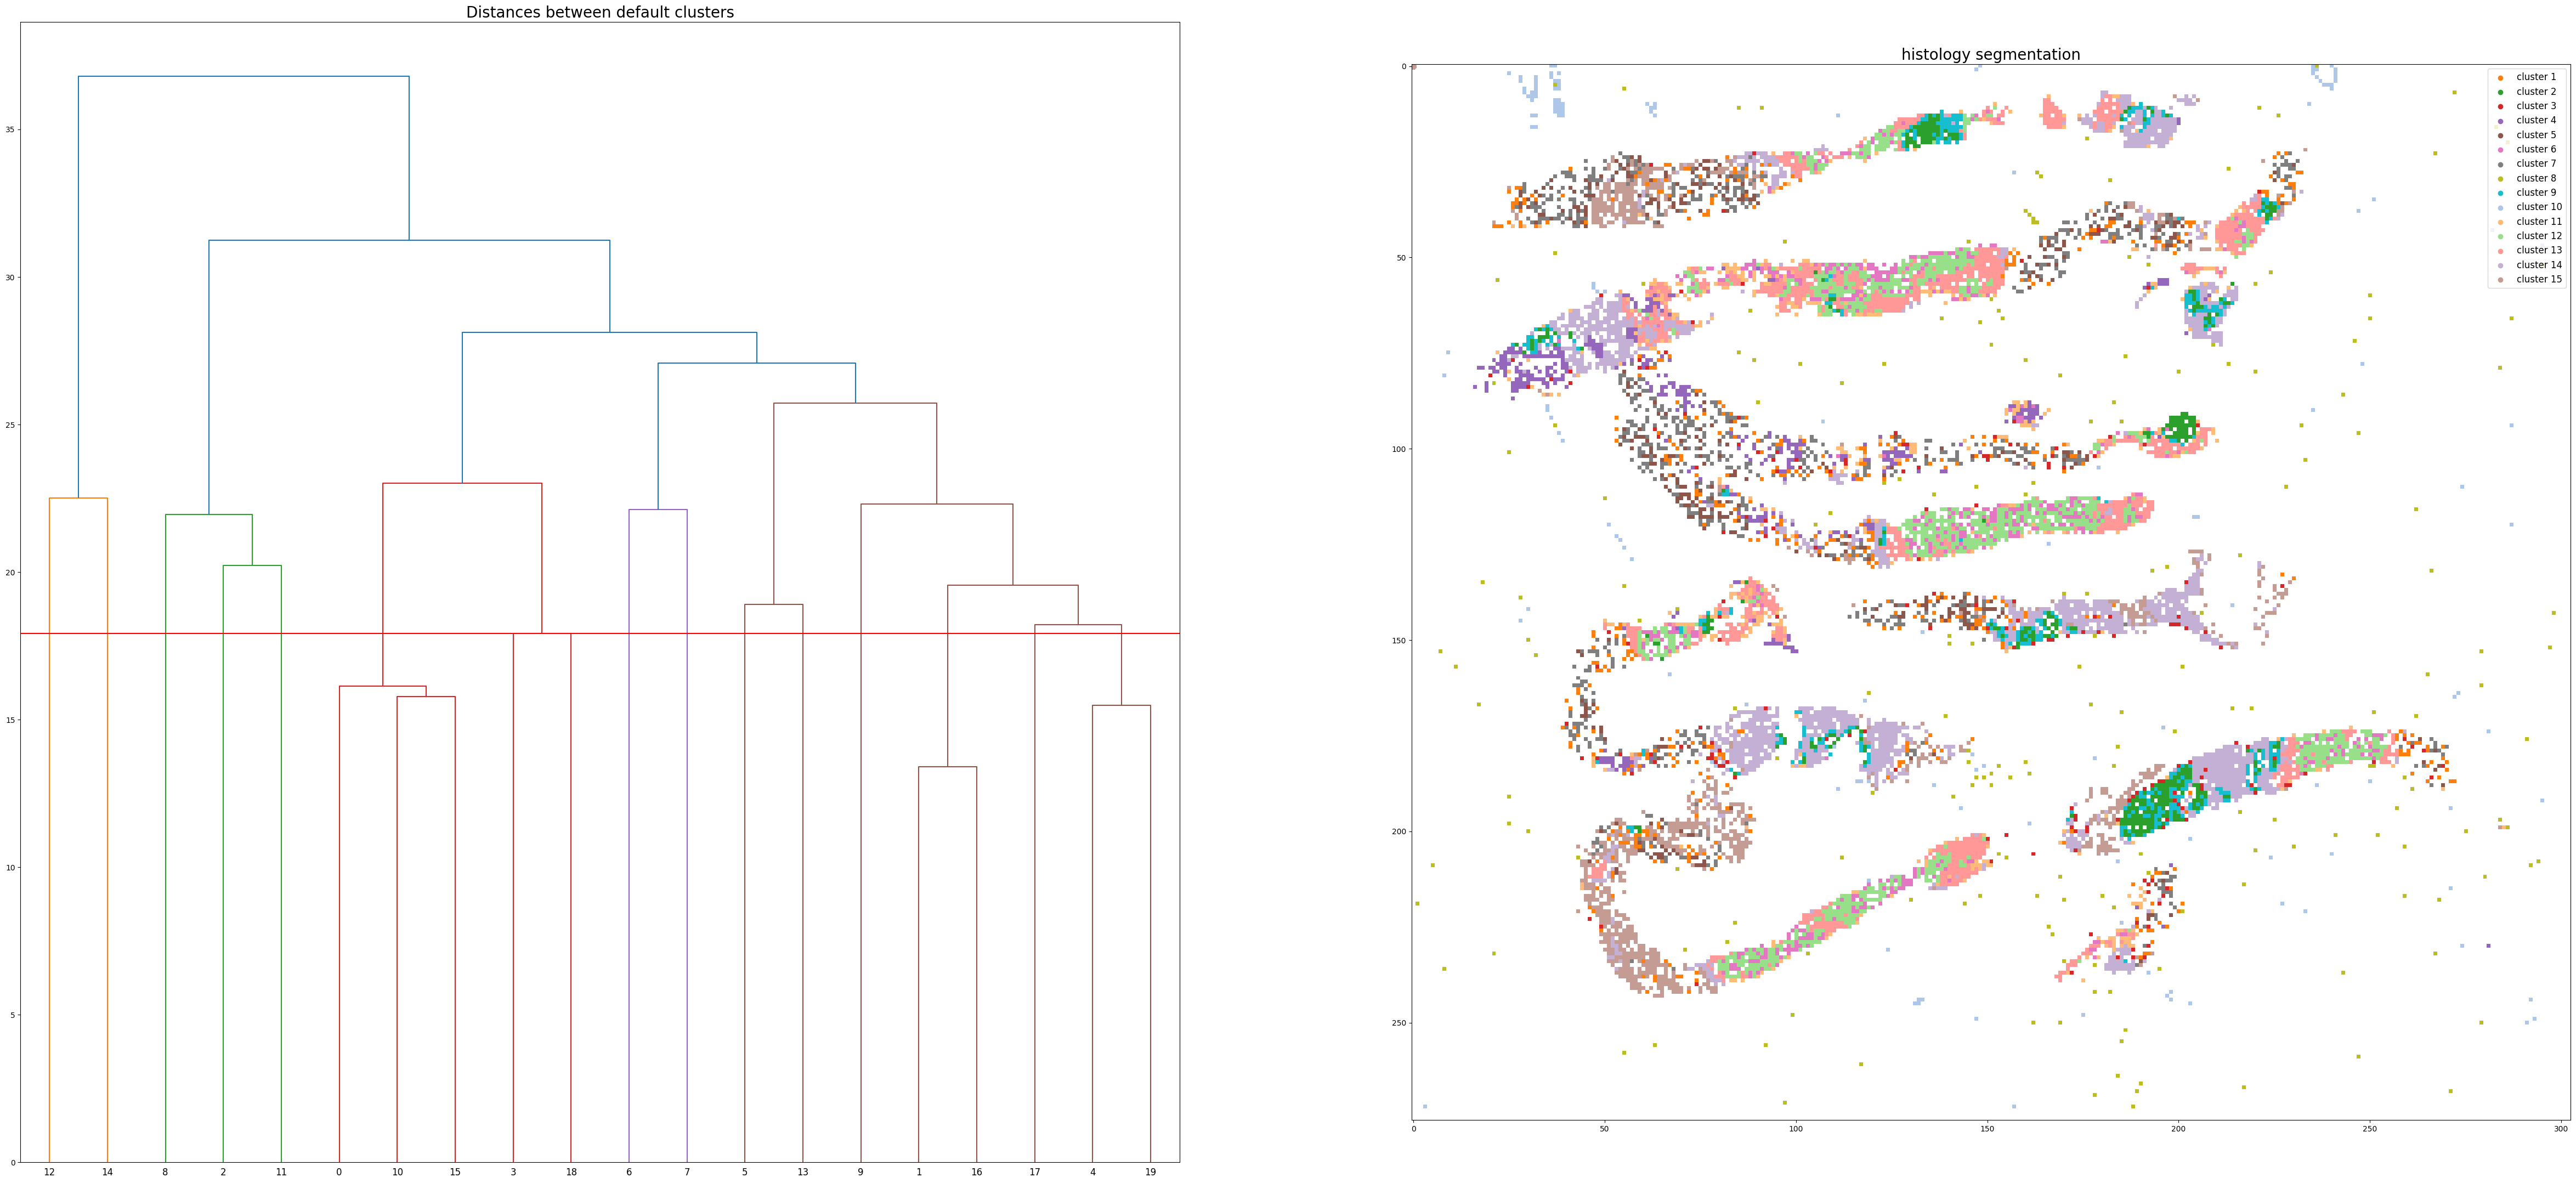

In [5]:
from p5_merge_over_clusters import merge_over_clusters

merge_over_clusters(prefix, save_folder,
                    target_n_clusters=15)

# Step 6: Select best ROI for TMA experiment

Image loaded from ../demo/Tutorial_4_TMA_selection_breast/he.jpg
Pickle loaded from ../demo/Tutorial_4_TMA_selection_breast/S2Omics_output/pickle_files/shapes.pickle
Pickle loaded from ../demo/Tutorial_4_TMA_selection_breast/S2Omics_output/pickle_files/qc_preserve_indicator.pickle
Pickle loaded from ../demo/Tutorial_4_TMA_selection_breast/S2Omics_output/pickle_files/adjusted_cluster_image.pickle
Sampling ROI candidates...


100%|██████████| 216500/216500 [00:40<00:00, 5347.76it/s]


Current best ROI: [[229, 181]]
    roi score: 0.6396056984164683
    scale score: 0.5054264734589632
    valid score: 0.9500815055860402
    balance score: 0.5449016500426276
Current number of ROIs is 1.


100%|██████████| 216500/216500 [00:45<00:00, 4723.20it/s]


Current best ROI: [[61, 203], [229, 182]]
    roi score: 0.6780723924490528
    scale score: 0.5087775616395698
    valid score: 0.8544521610805494
    balance score: 0.7171540997816747
Current number of ROIs is 2.


100%|██████████| 216500/216500 [00:46<00:00, 4674.25it/s]


Current best ROI: [[61, 203], [229, 182], [35, 74]]
    roi score: 0.6969127243412151
    scale score: 0.5125000549624169
    valid score: 0.8325955436062809
    balance score: 0.793244708419644
Current number of ROIs is 3.


100%|██████████| 216500/216500 [00:50<00:00, 4280.57it/s]


Current best ROI: [[61, 203], [229, 182], [201, 187], [126, 101]]
    roi score: 0.7088526082082967
    scale score: 0.5161148678750915
    valid score: 0.8187514777396648
    balance score: 0.8428870046522985
Current number of ROIs is 4.
Found the optimal number of ROI: 2. Program finished.
Find the best 2 ROI(s) with: 
    ROI score: 0.6780723924490528
    Scale score: 0.5087775616395698
    Coverage score: 0.8544521610805494
    Balance score: 0.7171540997816747
    
../demo/Tutorial_4_TMA_selection_breast/S2Omics_output/roi_selection_detailed_output/circle_roi_size_0.5_0.5/prior_preference_1/best_roi.pickle
Best ROI on histology segmentation image is stored at ../demo/Tutorial_4_TMA_selection_breast/S2Omics_output/main_output/best_roi_on_histology_segmentations.jpg
Best ROI on H&E image is stored at ../demo/Tutorial_4_TMA_selection_breast/S2Omics_output/main_output/best_roi_on_he.jpg


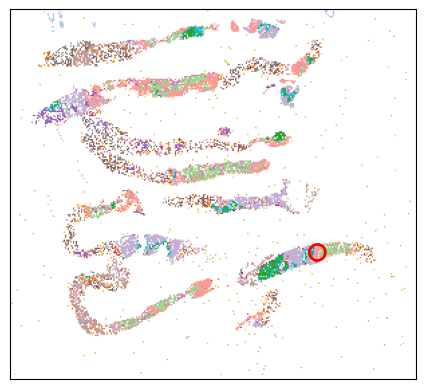

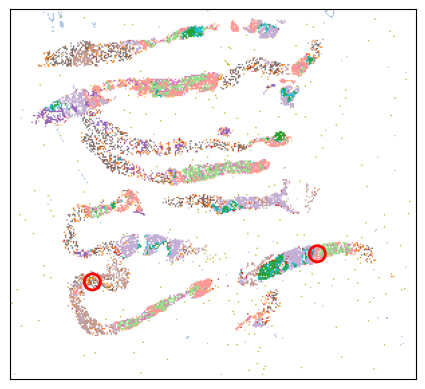

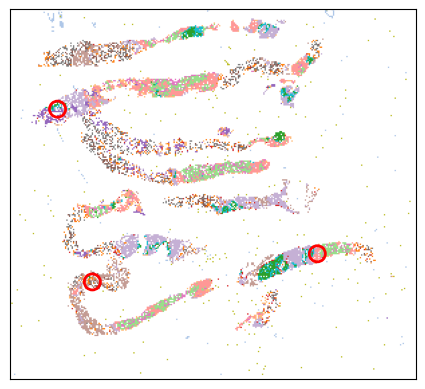

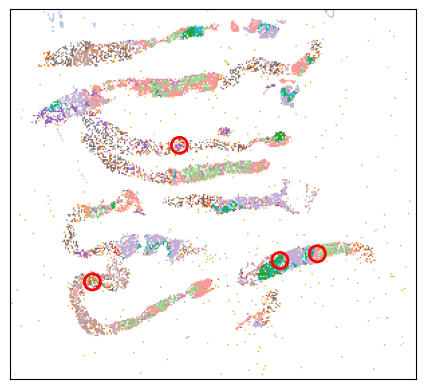

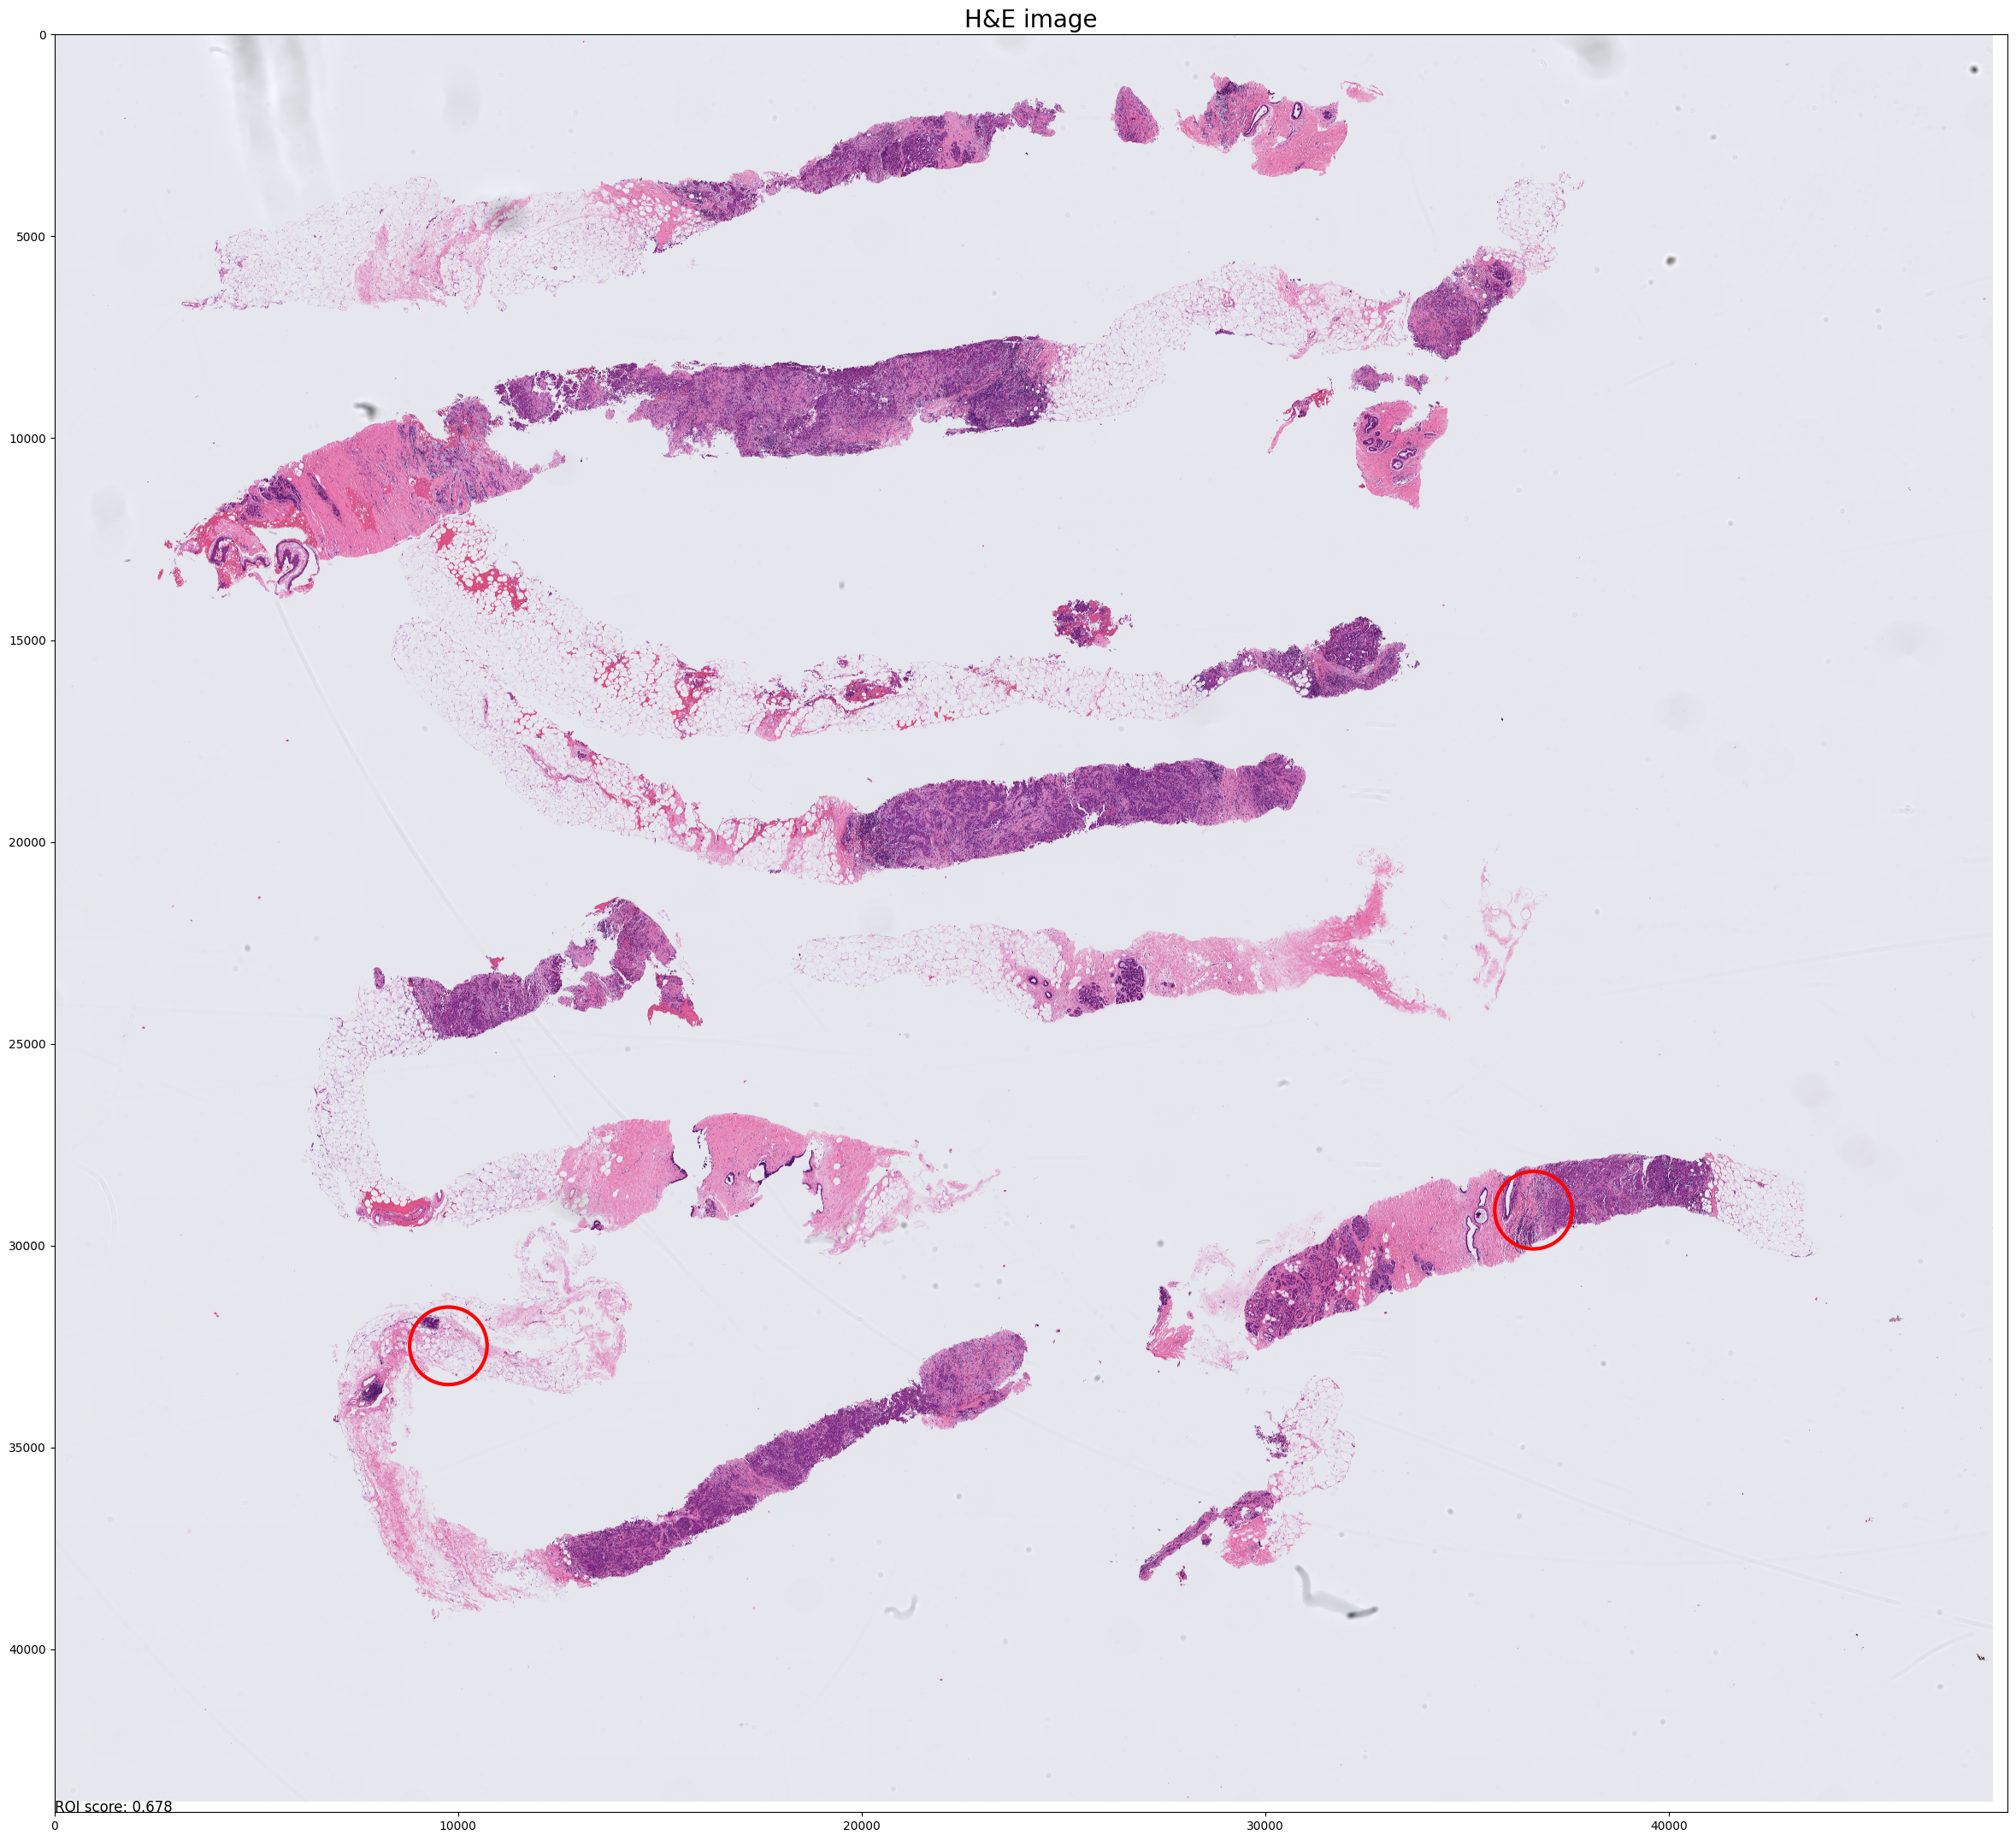

In [4]:
from p6_roi_selection_circle import roi_selection_for_single_section

# fusion_weights: the weight of three scores, default=[0.33,0.33,0.33], the sum of three weights should be equal to 1 (if not they will be normalized)
# positive_prior, negative_prior: prior information about interested and not-interested histology clusters, default = [],[]
# prior_preference: the larger this parameter is, S2Omics will focus more on those interested histology clusters, default=  1
roi_selection_for_single_section(prefix, save_folder,
                                 down_samp_step=10,
                                 roi_size=[0.5,0.5],
                                 num_roi=0, #0 refers to automatiacally determine the number of ROI
                                 fusion_weights=[0.33,0.33,0.33],
                                 emphasize_clusters=[], discard_clusters=[],
                                 prior_preference=1)